In [339]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn.metrics as met
from datetime import datetime,timedelta
import math


In [2]:
br=pd.read_excel('CustomerBehaviorData.xlsx')

dm=pd.read_excel('CustomerDemographics.xlsx')

cc=pd.read_excel('CreditConsumptionData.xlsx')



<AxesSubplot:>

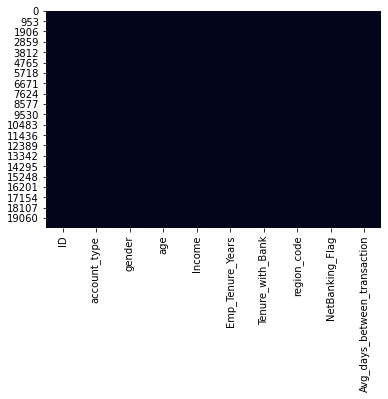

In [3]:
sns.heatmap(dm.isnull(), cbar=False)

In [4]:
dm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   account_type                  19999 non-null  object 
 2   gender                        19999 non-null  object 
 3   age                           20000 non-null  int64  
 4   Income                        19999 non-null  object 
 5   Emp_Tenure_Years              20000 non-null  float64
 6   Tenure_with_Bank              20000 non-null  int64  
 7   region_code                   19999 non-null  float64
 8   NetBanking_Flag               20000 non-null  int64  
 9   Avg_days_between_transaction  19997 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 1.5+ MB


<AxesSubplot:xlabel='gender', ylabel='count'>

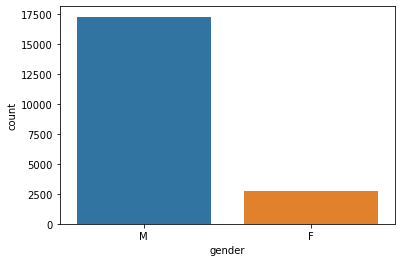

In [5]:
sns.countplot(x='gender',data=dm)

In [6]:
#checking for missing values
br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     20000 non-null  int64  
 1   cc_cons_apr            20000 non-null  float64
 2   dc_cons_apr            20000 non-null  float64
 3   cc_cons_may            19999 non-null  float64
 4   dc_cons_may            20000 non-null  float64
 5   cc_cons_jun            20000 non-null  float64
 6   dc_cons_jun            19999 non-null  float64
 7   cc_count_apr           19999 non-null  float64
 8   cc_count_may           20000 non-null  int64  
 9   cc_count_jun           20000 non-null  int64  
 10  dc_count_apr           20000 non-null  int64  
 11  dc_count_may           20000 non-null  int64  
 12  dc_count_jun           20000 non-null  int64  
 13  card_lim               20000 non-null  int64  
 14  personal_loan_active   20000 non-null  int64  
 15  ve

In [7]:
# total number of missing values
br.loan_enq.isna().sum()

2

In [18]:
# joining the data sets 
df=pd.merge(br,dm,on='ID')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 48 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons_apr                   20000 non-null  float64
 2   dc_cons_apr                   20000 non-null  float64
 3   cc_cons_may                   19999 non-null  float64
 4   dc_cons_may                   20000 non-null  float64
 5   cc_cons_jun                   20000 non-null  float64
 6   dc_cons_jun                   19999 non-null  float64
 7   cc_count_apr                  19999 non-null  float64
 8   cc_count_may                  20000 non-null  int64  
 9   cc_count_jun                  20000 non-null  int64  
 10  dc_count_apr                  20000 non-null  int64  
 11  dc_count_may                  20000 non-null  int64  
 12  dc_count_jun                  20000 non-null  int64  
 13  c

In [26]:
# total number of missing values
sum(df.isna().sum())

0

In [24]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) 
    elif (x.dtypes == 'object') :
        x = x.fillna(x.mode()[0])
    
    return x

In [25]:
#applying the function 
df=df.apply(missing_imputation)

In [27]:
# joining the data sets cc
df=pd.merge(df,cc,on='ID')

In [32]:
#dropping ID as we dont need it 
df.drop('ID',axis=1, inplace = True)

In [37]:
# total number of missing values
sum(df.isna().sum())

5000

In [42]:
#seperating the predict data ( QN is when we seperate the data, then we do not have the 5000 x variables
#will that have an effect on outlier treatment ? )
pred=df[df.cc_cons.isna()]

In [40]:
# df_new contains all the data including cc_cons, will be using this as final data set 
df.dropna(axis=0,inplace = True)

In [41]:
df.shape

(15000, 48)

In [43]:
# seperating continous and categorical variables 
df_conti = df.loc[:, (df.dtypes == 'float64') | (df.dtypes == 'int64')]
df_cat = df.loc[:, (df.dtypes == 'object')]

In [46]:
# outlier Treatment
df_conti = df_conti.apply( lambda x: x.clip(lower = x.quantile(0.01), 
                                                         upper = x.quantile(0.99)) )

In [51]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

In [52]:
# # another method for creating dummies 
for c_feature in df_cat:
    df_cat[c_feature] = df_cat[c_feature].astype('category')
    df_cat= create_dummies(df_cat, c_feature)

<ipython-input-52-425a8eb4e296>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[c_feature] = df_cat[c_feature].astype('category')


In [54]:
df_cat.head()

,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,0,1,0,1
1,0,1,1,0
2,0,1,0,1
3,0,1,1,0
4,1,1,0,1


In [55]:
# Final DATA for analysis 
df_new=pd.concat([df_conti, df_cat], axis = 1)

In [56]:
df_new

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,...,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,3412.60,2909.34,1077.36,3084.50,4615.97,6693.00,19.0,10,2,53,...,7.0,5,956.0,1,20.0,13434.00,0,1,0,1
1,18133.76,3877.00,6123.78,5597.43,64620.00,6117.00,4.0,60,1,4,...,10.2,8,966.0,1,5.0,449.00,0,1,1,0
2,6363.65,735.49,8799.00,13768.00,38266.00,2638.00,2.0,83,47,4,...,3.9,3,505.0,1,15.0,11968.00,0,1,0,1
3,12765.66,4429.16,16745.86,6360.00,29063.97,3711.00,12.0,2,16,24,...,25.8,6,631.0,0,15.0,32029.00,0,1,1,0
4,27819.70,1944.00,7006.50,2228.50,1096.25,1065.00,15.0,13,61,7,...,6.5,7,698.0,0,9.0,16394.00,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,10443.76,1218.85,7252.24,3873.00,6633.00,10107.00,3.0,36,3,44,...,13.2,9,653.0,1,20.0,4263.00,0,0,1,0
14996,29890.33,6308.00,16025.50,7610.00,2213.08,841.60,1.0,34,4,7,...,2.4,9,535.0,1,2.0,11019.00,0,1,0,1
14997,4148.98,948.74,19360.26,494.00,44363.91,1801.77,57.0,23,61,24,...,3.4,9,464.0,1,8.0,395290.55,0,1,0,1
14998,115574.00,7191.05,44341.13,34817.20,20679.00,1010.00,7.0,128,44,3,...,40.0,10,536.0,1,3.0,28813.00,0,1,0,1


/Users/abin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


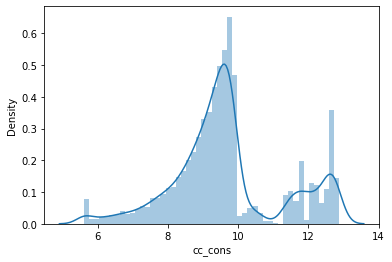

In [58]:
# Testing Variable for skewdness
sns.distplot(np.log(df_new.cc_cons))
plt.show()

In [59]:
df_new['ln_cc']=np.log(df_new.cc_cons)

/Users/abin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


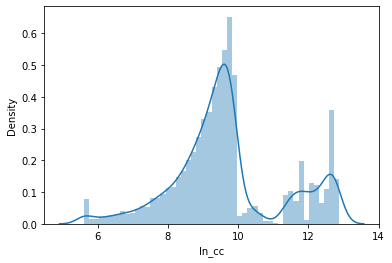

In [60]:
# Distribution of variables
sns.distplot(df_new.ln_cc )
plt.show()

In [61]:
df_new.ln_cc.skew()

0.2731907940636718

In [79]:
# Linearity: correlation matrix (ranges from 1 to -1)
corrm = df_new.corr()
corrm.to_csv('corrm.csv')
corrm

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,...,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons,account_type_saving,gender_M,Income_LOW,Income_MEDIUM,ln_cc
cc_cons_apr,1.000000,-0.000592,0.012623,0.006572,0.004569,-0.001050,0.000990,-0.001905,0.009504,0.001698,...,-0.008530,0.002106,0.002184,0.011558,0.006077,0.015393,0.005912,-0.010028,0.014181,0.008731
dc_cons_apr,-0.000592,1.000000,0.004555,-0.001436,0.004465,-0.006944,0.004758,0.000811,0.008879,0.002607,...,-0.004752,-0.008462,-0.006853,0.003782,0.001473,0.004550,-0.002228,0.011243,-0.009988,0.009193
cc_cons_may,0.012623,0.004555,1.000000,-0.011308,-0.019162,0.001065,-0.011654,0.009556,-0.012828,-0.008015,...,0.016142,-0.005641,0.006025,0.015396,0.020469,0.001255,0.007212,-0.018764,0.014332,0.022976
dc_cons_may,0.006572,-0.001436,-0.011308,1.000000,-0.005935,0.004672,-0.007892,-0.011366,-0.009936,-0.020795,...,0.017183,-0.004576,0.000906,0.009159,-0.009181,0.001913,-0.004440,-0.003283,-0.005776,-0.005761
cc_cons_jun,0.004569,0.004465,-0.019162,-0.005935,1.000000,-0.003829,0.002029,-0.007346,0.011675,-0.009717,...,-0.011187,-0.005794,-0.003292,0.003425,-0.000248,-0.016296,0.008237,0.007047,-0.010933,0.004634
dc_cons_jun,-0.001050,-0.006944,0.001065,0.004672,-0.003829,1.000000,-0.007348,-0.000128,0.012615,0.000628,...,-0.007532,0.012504,0.002005,-0.002342,0.000240,0.005683,0.004947,0.004399,-0.006554,-0.005801
cc_count_apr,0.000990,0.004758,-0.011654,-0.007892,0.002029,-0.007348,1.000000,-0.003170,0.001608,-0.006683,...,0.012032,-0.003677,0.012865,-0.015964,-0.009700,-0.000574,0.010392,0.002051,0.000861,-0.015191
cc_count_may,-0.001905,0.000811,0.009556,-0.011366,-0.007346,-0.000128,-0.003170,1.000000,-0.002944,0.006317,...,-0.009162,-0.003858,0.011619,0.009335,0.016088,0.000508,-0.005165,0.004625,-0.001725,0.016129
cc_count_jun,0.009504,0.008879,-0.012828,-0.009936,0.011675,0.012615,0.001608,-0.002944,1.000000,-0.002879,...,-0.008180,-0.007867,-0.001610,-0.001389,0.002119,-0.018810,0.005928,0.011363,-0.011297,0.003056
dc_count_apr,0.001698,0.002607,-0.008015,-0.020795,-0.009717,0.000628,-0.006683,0.006317,-0.002879,1.000000,...,0.002606,-0.017035,0.010333,0.002409,-0.000495,0.013159,0.006691,0.005676,0.002108,0.002819


In [80]:
df_new.columns

Index(['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
       'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
       'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
       'card_lim', 'investment_1', 'investment_2', 'investment_3',
       'investment_4', 'debit_amount_apr', 'credit_amount_apr',
       'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr',
       'debit_amount_may', 'credit_amount_may', 'credit_count_may',
       'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun',
       'credit_amount_jun', 'credit_count_jun', 'debit_count_jun',
       'max_credit_amount_jun', 'emi_active', 'age', 'Emp_Tenure_Years',
       'Tenure_with_Bank', 'region_code', 'NetBanking_Flag',
       'Avg_days_between_transaction', 'cc_cons', 'account_type_saving',
       'gender_M', 'Income_LOW', 'Income_MEDIUM', 'ln_cc'],
      dtype='object')

In [78]:
df_new.drop(['personal_loan_active', 'vehicle_loan_active','personal_loan_closed', 'vehicle_loan_closed'], axis =1, inplace = True)

<AxesSubplot:>

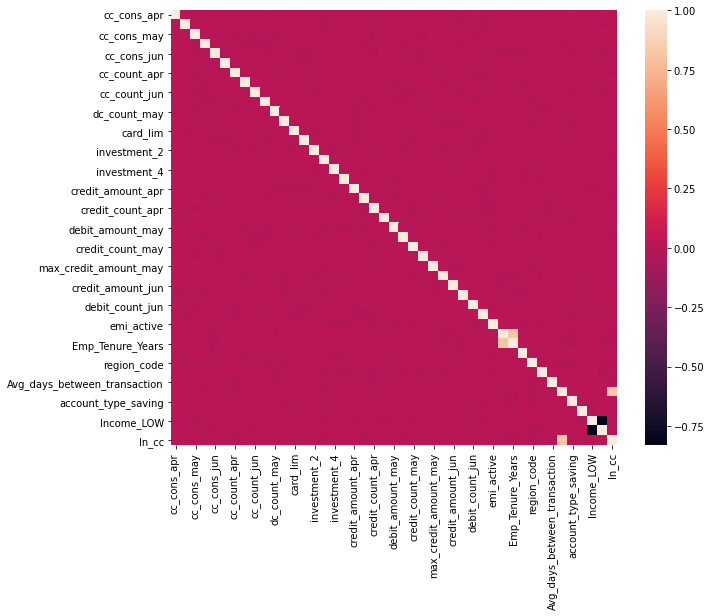

In [81]:
# visualize correlation matrix in Seaborn using a heatmap
plt.figure(figsize = (10, 8))
sns.heatmap(df_new.corr())

In [97]:
# checking correlation with Y variable 
corrwith_y = df_new.corrwith(df_new.ln_cc)
corrwith_y.to_csv('corrwith_y.csv')

In [99]:
#checking coefficent of variation ( if COV is low we can drop the variables)
cov=df_new.apply(lambda x:x.std()/x.mean())

In [105]:
cov=pd.DataFrame(cov, columns=['cov'])

In [106]:
cov.sort_values('cov', ascending = False)

,cov
investment_1,3.519763
account_type_saving,2.366343
cc_count_apr,2.348356
emi_active,2.136359
investment_4,2.013605
investment_3,1.982665
cc_cons,1.768518
Income_LOW,1.606809
dc_cons_jun,1.544232
investment_2,1.425184


## Variable Reduction 

In [107]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression, RFE, SelectKBest
F_values, p_values  = f_regression( features, target )

In [83]:
# recursive feature elimination 
features = df_new[df_new.columns.difference( ['ln_cc', 'cc_cons'] )]
target = df_new['ln_cc']

In [110]:
# if F value is high P value will be low 
F_values

array([1.78559877e+00, 2.41129608e+00, 2.32863282e-01, 9.79851970e-01,
       2.10502259e-02, 5.49758860e-01, 4.20909651e-01, 1.47928265e+00,
       7.11262574e-01, 1.14347718e+00, 3.22142622e-01, 7.92127883e+00,
       3.46199071e+00, 1.40076846e-01, 3.90251179e+00, 4.96591602e+00,
       2.22736095e-01, 1.72968877e+00, 1.33638242e-02, 5.77044636e-01,
       2.87658259e-01, 1.26748015e+00, 5.04797339e-01, 4.97755864e-01,
       1.19146172e-01, 2.35737628e-01, 4.04101545e-01, 3.94342470e-02,
       4.59637821e-01, 4.35750480e-01, 1.47759781e+00, 5.24148347e-01,
       1.30122079e-01, 6.75985295e-01, 5.05874905e-02, 2.40152376e-01,
       6.02232762e-01, 2.17932288e+00, 1.80132661e-02, 3.37348479e-03,
       1.55886791e+00, 7.52913251e-02, 1.27776883e+00])

In [109]:
# if p value is low, then variable is having strong relationship with Y 
p_values

array([0.1814836 , 0.12048369, 0.62941587, 0.32225132, 0.88464416,
       0.45842785, 0.51649343, 0.22390593, 0.39903844, 0.28493599,
       0.57033134, 0.00489204, 0.06281423, 0.70820992, 0.04823228,
       0.02586638, 0.63696988, 0.18847076, 0.90796952, 0.44748501,
       0.59173305, 0.26025795, 0.47741081, 0.4804988 , 0.72996723,
       0.62730881, 0.52498831, 0.84259354, 0.49780375, 0.50919082,
       0.22416988, 0.46908875, 0.71831058, 0.41098568, 0.8220472 ,
       0.62410325, 0.43773963, 0.13989698, 0.89323554, 0.95368432,
       0.21185055, 0.78378667, 0.25833237])

In [111]:
f_reg_results = pd.concat([pd.Series(features.columns), pd.Series(F_values), pd.Series(p_values)], axis=1)

In [112]:
f_reg_results.columns = ['Feature', 'F_value', 'P_Value']

In [114]:
f_reg_results.sort_values(by='P_Value', ascending=True, inplace=True)

In [223]:
# consider p values that are less than 0.1
k=f_reg_results.iloc[:15,0]

In [390]:
#setting the features columns
features=df_new[k]
features

,cc_cons_may,credit_amount_apr,cc_count_may,cc_count_apr,Emp_Tenure_Years,investment_3,Avg_days_between_transaction,credit_amount_may,max_credit_amount_jun,age,debit_count_apr,region_code,dc_cons_apr,cc_cons_apr,Income_MEDIUM
0,1077.36,27532.3700,10,19.0,7.0,300500.0,20.0,42852.00,19947.00,30,103.0,956.0,2909.34,3412.60,1
1,6123.78,50784.0000,60,4.0,10.2,610000.0,5.0,24257.00,20585.00,37,40.0,966.0,3877.00,18133.76,0
2,8799.00,26345.0000,83,2.0,3.9,2156.0,15.0,38306.00,13950.00,33,11.0,505.0,735.49,6363.65,1
3,16745.86,49660.0000,2,12.0,25.8,26241.0,15.0,46132.05,37018.00,63,42.0,631.0,4429.16,12765.66,0
4,7006.50,567755.1992,13,15.0,6.5,13873.0,9.0,37191.00,24274.00,33,46.0,698.0,1944.00,27819.70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,7252.24,31135.0000,36,3.0,13.2,16215.0,20.0,23692.00,82851.00,53,79.0,653.0,1218.85,10443.76,0
14996,16025.50,23797.0000,34,1.0,2.4,12337.0,2.0,50023.00,118110.47,44,43.0,535.0,6308.00,29890.33,1
14997,19360.26,95477.2700,23,57.0,3.4,25000.0,8.0,35239.00,49545.00,37,4.0,464.0,948.74,4148.98,1
14998,44341.13,59644.0000,128,7.0,40.0,3975.0,3.0,82193.00,16130.00,220,3.0,536.0,7191.05,115574.00,1


In [117]:
# Recrusive Feature Elimination RFE to reduce variables 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [119]:
rfe = RFE(LinearRegression(), n_features_to_select=10)
rfe = rfe.fit(features, target )
rfe.support_

array([ True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False,  True, False,
       False, False, False, False, False, False, False])

In [120]:
features.columns[rfe.support_]

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW',
       'Income_MEDIUM', 'NetBanking_Flag', 'Tenure_with_Bank',
       'account_type_saving', 'cc_count_may', 'debit_count_apr', 'gender_M'],
      dtype='object')

In [125]:
# Checking for multicollinerarity Using VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [198]:

vif_values = pd.Series([variance_inflation_factor(features.values, exog_idx= i) for i in range(0, len(features.columns))])

In [199]:
vif_values1 = pd.concat([pd.Series(features.columns), vif_values], axis=1)

In [200]:
vif_values1.columns = ['feature', 'vif']

In [201]:
 vif_values1.sort_values(by='vif', ascending=False)

,feature,vif
9,age,9.404335
11,region_code,5.814226
4,Emp_Tenure_Years,5.122777
6,Avg_days_between_transaction,4.177827
14,Income_MEDIUM,2.571124
10,debit_count_apr,2.263859
2,cc_count_may,1.967432
7,credit_amount_may,1.722520
1,credit_amount_apr,1.656561
13,cc_cons_apr,1.640616


In [260]:

features=features[features.columns.difference(['age'])]
target = df_new['ln_cc']

vif_values = pd.Series([variance_inflation_factor(features.values, exog_idx= i) for i in range(0, len(features.columns))])

vif_values1 = pd.concat([pd.Series(features.columns), vif_values], axis=1)

vif_values1.columns = ['feature', 'vif']

vif_values1.sort_values(by='vif', ascending=False)

,feature,vif
13,region_code,5.548230
0,Avg_days_between_transaction,4.106297
2,Income_MEDIUM,2.545949
10,debit_count_apr,2.251188
6,cc_count_may,1.956518
8,credit_amount_may,1.717668
1,Emp_Tenure_Years,1.696615
7,credit_amount_apr,1.650104
12,max_credit_amount_jun,1.635262
3,cc_cons_apr,1.635224


## MODELING THE DATA 

In [221]:
#split the data into train & test

from sklearn.model_selection import train_test_split

In [261]:
df_final = pd.concat([target, features], axis=1)
df_final

,ln_cc,Avg_days_between_transaction,Emp_Tenure_Years,Income_MEDIUM,cc_cons_apr,cc_cons_may,cc_count_apr,cc_count_may,credit_amount_apr,credit_amount_may,dc_cons_apr,debit_count_apr,investment_3,max_credit_amount_jun,region_code
0,9.505544,20.0,7.0,1,3412.60,1077.36,19.0,10,27532.3700,42852.00,2909.34,103.0,300500.0,19947.00,956.0
1,6.107023,5.0,10.2,0,18133.76,6123.78,4.0,60,50784.0000,24257.00,3877.00,40.0,610000.0,20585.00,966.0
2,9.389992,15.0,3.9,1,6363.65,8799.00,2.0,83,26345.0000,38306.00,735.49,11.0,2156.0,13950.00,505.0
3,10.374397,15.0,25.8,0,12765.66,16745.86,12.0,2,49660.0000,46132.05,4429.16,42.0,26241.0,37018.00,631.0
4,9.704671,9.0,6.5,1,27819.70,7006.50,15.0,13,567755.1992,37191.00,1944.00,46.0,13873.0,24274.00,698.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,8.357728,20.0,13.2,0,10443.76,7252.24,3.0,36,31135.0000,23692.00,1218.85,79.0,16215.0,82851.00,653.0
14996,9.307376,2.0,2.4,1,29890.33,16025.50,1.0,34,23797.0000,50023.00,6308.00,43.0,12337.0,118110.47,535.0
14997,12.887376,8.0,3.4,1,4148.98,19360.26,57.0,23,95477.2700,35239.00,948.74,4.0,25000.0,49545.00,464.0
14998,10.268582,3.0,40.0,1,115574.00,44341.13,7.0,128,59644.0000,82193.00,7191.05,3.0,3975.0,16130.00,536.0


(15000, 15)

In [393]:
train, test = train_test_split(df_final, test_size =0.3, random_state = 123)

In [394]:
train.shape

(10500, 15)

In [395]:
test.shape

(4500, 15)

In [264]:
train.columns

Index(['ln_cc', 'Avg_days_between_transaction', 'Emp_Tenure_Years',
       'Income_MEDIUM', 'cc_cons_apr', 'cc_cons_may', 'cc_count_apr',
       'cc_count_may', 'credit_amount_apr', 'credit_amount_may', 'dc_cons_apr',
       'debit_count_apr', 'investment_3', 'max_credit_amount_jun',
       'region_code'],
      dtype='object')

In [237]:
# Model building on train data
import statsmodels.formula.api as smf

In [265]:
ols_model = smf.ols('''ln_cc~Avg_days_between_transaction+Emp_Tenure_Years+Income_MEDIUM+cc_cons_apr+cc_cons_may
                    + cc_count_apr+cc_count_may+credit_amount_apr+credit_amount_may+dc_cons_apr
                    +debit_count_apr+investment_3+max_credit_amount_jun+region_code''', data=train).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ln_cc   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.650
Date:                Mon, 23 Aug 2021   Prob (F-statistic):             0.0588
Time:                        18:01:30   Log-Likelihood:                -19660.
No. Observations:               10500   AIC:                         3.935e+04
Df Residuals:                   10485   BIC:                         3.946e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

## MODEL 2 using K nearest neighbhors 

In [258]:
from sklearn.neighbors import KNeighborsRegressor

In [385]:
X=features
y=target

In [398]:
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.3, random_state = 123)

In [402]:
test_X.shape

(4500, 14)

In [291]:
# Standardize the data

from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [303]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [313]:
x_train_scaled = scaler.fit_transform(train_X) # performing z transformation 
x_train = pd.DataFrame(x_train_scaled)#fit method will calculate mean and standard deviation of each X variable in the train_X


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.944444,0.024938,0.0,0.015979,0.018824,0.009434,0.102362,0.088850,0.419107,0.095931,0.609589,0.081207,0.043025,0.288435
1,0.333333,0.258520,1.0,0.018075,0.044495,0.111321,0.173228,0.021621,0.208943,0.030887,0.308219,0.021375,0.110145,0.346939
2,0.611111,0.158770,0.0,0.069883,0.023124,0.000000,0.259843,0.091836,0.187137,0.020824,0.424658,0.019413,0.027256,0.189116
3,0.166667,0.050707,1.0,0.031398,0.090202,0.079245,0.196850,0.000000,0.110443,0.044017,0.260274,0.018171,0.113051,0.019048
4,1.000000,0.216958,1.0,0.011710,0.090942,0.047170,0.511811,0.040865,0.265947,0.058342,0.068493,0.018860,0.048596,0.414966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,0.222222,0.399834,0.0,0.136062,0.037621,0.011321,1.000000,0.111751,0.187269,0.001065,0.534247,0.054585,0.157746,0.014966
10496,0.166667,0.039069,0.0,0.052570,0.013556,0.103774,0.000000,0.069190,0.001805,0.033061,0.102740,0.005029,0.063070,0.189116
10497,1.000000,0.049044,1.0,0.080710,0.086069,0.001887,0.228346,0.051884,0.127204,0.026540,0.068493,0.018860,0.115788,0.043537
10498,0.666667,0.004156,1.0,0.042222,0.010875,0.011321,0.220472,0.167763,0.172928,0.260706,0.061644,0.006059,0.095912,0.412245


In [306]:
x_test_scaled = scaler.fit_transform(test_X)
x_test = pd.DataFrame(x_test_scaled)

In [308]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import neighbors

In [310]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, train_y)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(test_y,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 2.2645683496398474
RMSE value for k=  2 is: 1.9263838207514927
RMSE value for k=  3 is: 1.8259808664861803
RMSE value for k=  4 is: 1.7729631284314396
RMSE value for k=  5 is: 1.7468885711397755
RMSE value for k=  6 is: 1.7206765464285858
RMSE value for k=  7 is: 1.7051020922084206
RMSE value for k=  8 is: 1.6914298492099324
RMSE value for k=  9 is: 1.6791108530547694
RMSE value for k=  10 is: 1.6701895052187243
RMSE value for k=  11 is: 1.6627142118922509
RMSE value for k=  12 is: 1.6580659046055974
RMSE value for k=  13 is: 1.653802758899488
RMSE value for k=  14 is: 1.6487175314195992
RMSE value for k=  15 is: 1.6450010957159868
RMSE value for k=  16 is: 1.6370355121292663
RMSE value for k=  17 is: 1.634469979788813
RMSE value for k=  18 is: 1.6340833219057003
RMSE value for k=  19 is: 1.6323150030913902
RMSE value for k=  20 is: 1.6283643787129711


In [327]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10], 'weights':['distance','uniform']}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5, scoring='neg_root_mean_squared_error')
model.fit(x_train,train_y)
model.best_params_

{'n_neighbors': 10, 'weights': 'uniform'}

In [318]:
import sklearn

In [319]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [325]:
model.best_score_

-1.6446676046356206

In [344]:
train_y

5242      8.605753
12675     6.458338
6924      9.291552
12596     6.566672
12569     9.896010
           ...    
5218     12.609522
12252    12.103918
1346      8.699515
11646    12.735494
3582      8.958025
Name: ln_cc, Length: 10500, dtype: float64

## MODEL 3 DECISION TREE 

In [345]:
from sklearn.tree import DecisionTreeRegressor, export_text

In [352]:
modeldt=DecisionTreeRegressor( random_state=0)

In [353]:
modeldt.fit(X=train_X,y=train_y)

DecisionTreeRegressor(random_state=0)

In [358]:
y_pred = modeldt.predict(test_X)

In [359]:
y_pred

array([12.73953511, 11.86983738,  7.67600993, ..., 12.5673455 ,
        9.14473461,  7.11558213])

In [360]:
met.mean_squared_error(test_y,y_pred)

5.302150368978819

## MODEL 4 Random Forest 

In [361]:
from sklearn.ensemble import RandomForestRegressor

In [362]:
rf_model = RandomForestRegressor()

In [363]:
rf_model=rf_model.fit(train_X,train_y)

In [403]:
rf_pred = rf_model.predict(test_X)

In [404]:
met.mean_squared_error(test_y,rf_pred)

2.5742812278328366